# 신경망 성능 개선

신경망의 예측 성능 및 수렴 성능을 개선하기 위해서는 다음과 같은 추가적인 고려를 해야 한다.

* 오차(목적) 함수 개선: cross-entropy cost function
* 정규화: regularization
* 가중치 초기값: weight initialization
* Softmax 출력
* Activation 함수 선택: hyper-tangent and ReLu


## 기울기와 수렴 속도 문제

일반적으로 사용하는 잔차 제곱합(sum of square) 형태의 오차 함수는 대부분의 경우에 기울기 값이 0 이므로 (near-zero gradient) 수렴이 느려지는 단점이 있다.

* http://neuralnetworksanddeeplearning.com/chap3.html

$$
\begin{eqnarray}
z = \sigma (wx+b)
\end{eqnarray}
$$

$$
\begin{eqnarray}
  C = \frac{(y-z)^2}{2},
\end{eqnarray}
$$


$$
\begin{eqnarray} 
  \frac{\partial C}{\partial w} & = & (z-y)\sigma'(a) x \\
  \frac{\partial C}{\partial b} & = & (z-y)\sigma'(a)
\end{eqnarray}
$$


* if $x=1$, $y=0$, 
$$
\begin{eqnarray} 
  \frac{\partial C}{\partial w} & = & a \sigma'(a) \\
  \frac{\partial C}{\partial b} & = & a \sigma'(z)
\end{eqnarray}
$$

* $\sigma'$는 대부분의 경우에 zero.

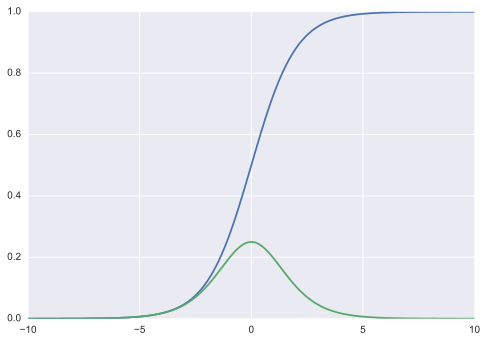

In [1]:
sigmoid = lambda x: 1/(1+np.exp(-x))
sigmoid_prime = lambda x: sigmoid(x)*(1-sigmoid(x))
xx = np.linspace(-10, 10, 1000)
plt.plot(xx, sigmoid(xx));
plt.plot(xx, sigmoid_prime(xx));

5나 10이 나오면 기울기값이 0이 나온다. 엄청 작게 나온다. (초록색 경우에). a값이 이렇게 나오면 weight update가 잘 안 되게 된다. 우리가 원하는 것은 반대다. a값이 크면 더 잘 안되는 효과가 나오니까. 그래서 새로 만들어 낸 것은 밑에 있는 교차 엔트로피 오차 함수이다.

## 교차 엔트로피 오차 함수 (Cross-Entropy Cost Function)

이러한 수렴 속도 문제를 해결하는 방법의 하나는 오차 제곱합 형태가 아닌 교차 엔트로피(Cross-Entropy) 형태의 오차함수를 사용하는 것이다.


$$
\begin{eqnarray} 
  C = -\frac{1}{n} \sum_x \left[y \ln z + (1-y) \ln (1-z) \right],
\end{eqnarray}
$$


미분값은 다음과 같다.

$$
\begin{eqnarray}
  \frac{\partial C}{\partial w_j} & = & -\frac{1}{n} \sum_x \left(
    \frac{y }{z} -\frac{(1-y)}{1-z} \right)
  \frac{\partial z}{\partial w_j} \\
 & = & -\frac{1}{n} \sum_x \left( 
    \frac{y}{\sigma(a)} 
    -\frac{(1-y)}{1-\sigma(a)} \right)\sigma'(a) x_j \\
 & = &
  \frac{1}{n}
  \sum_x \frac{\sigma'(a) x_j}{\sigma(a) (1-\sigma(a))}
  (\sigma(a)-y) \\
 & = & \frac{1}{n} \sum_x x_j(\sigma(a)-y) \\ 
 & = & \frac{1}{n} \sum_x (z-y) x_j\\ \\
\frac{\partial C}{\partial b} &=& \frac{1}{n} \sum_x (z-y)
\end{eqnarray}
$$

우리가 바라는 것은 z가 1이 되면 y가 1 or 0. 그래서 MSE와 같은 효과.

오차가 클 때는 미분값이 커서 슬로프가 커서 업데이트가 빨리 된다. 오차가 적으면 미분이 천천히 돼서 정밀하게 조정할 수가 있다.

이 식에서 보다시피 기울기(gradient)가 예측 오차(prediction error) $z-y$에 비례하기 때문에

 * 오차가 크면 수렴 속도가 빠르고
 * 오차가 적으면 속도가 감소하여 발산을 방지한다.

## 교차 엔트로피 구현 예

* https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/src/network2.py


```python
#### Define the quadratic and cross-entropy cost functions

class QuadraticCost(object):

    @staticmethod
    def fn(a, y):
        """Return the cost associated with an output ``a`` and desired output
        ``y``.
        """
        return 0.5*np.linalg.norm(a-y)**2

    @staticmethod
    def delta(z, a, y):   #여기 델타는 미분값을 의미한다.
        """Return the error delta from the output layer."""
        return (a-y) * sigmoid_prime(z)


class CrossEntropyCost(object):

    @staticmethod
    def fn(a, y):   #함수
        """Return the cost associated with an output ``a`` and desired output
        ``y``.  Note that np.nan_to_num is used to ensure numerical
        stability.  In particular, if both ``a`` and ``y`` have a 1.0
        in the same slot, then the expression (1-y)*np.log(1-a)
        returns nan.  The np.nan_to_num ensures that that is converted
        to the correct value (0.0).
        """
        return np.sum(np.nan_to_num(-y*np.log(a)-(1-y)*np.log(1-a)))   #nan은 로그 안에 이상한 값(음수나 0)이 들어가는 것. 그래서 0으로 들                                                                         #어가게끔

    @staticmethod
    def delta(z, a, y):
        """Return the error delta from the output layer.  Note that the
        parameter ``z`` is not used by the method.  It is included in
        the method's parameters in order to make the interface
        consistent with the delta method for other cost classes.
        """
        return (a-y)
```

In [2]:
%cd /home/dockeruser/neural-networks-and-deep-learning/src
%ls

/home/dockeruser/neural-networks-and-deep-learning/src
conv.py                    mnist_loader.py   network2.py  network.pyc
expand_mnist.py            mnist_loader.pyc  network3.py  old/
mnist_average_darkness.py  mnist_svm.py      network.py


In [3]:
import mnist_loader
import network2

training_data, validation_data, test_data = mnist_loader.load_data_wrapper()

In [4]:
net = network2.Network([784, 30, 10], cost=network2.QuadraticCost)
net.large_weight_initializer()
%time result1 = net.SGD(training_data, 10, 10, 0.5, evaluation_data=test_data, monitor_evaluation_accuracy=True)

Epoch 0 training complete
Accuracy on evaluation data: 8410 / 10000

Epoch 1 training complete
Accuracy on evaluation data: 8864 / 10000

Epoch 2 training complete
Accuracy on evaluation data: 9021 / 10000

Epoch 3 training complete
Accuracy on evaluation data: 9092 / 10000

Epoch 4 training complete
Accuracy on evaluation data: 9142 / 10000

Epoch 5 training complete
Accuracy on evaluation data: 9192 / 10000

Epoch 6 training complete
Accuracy on evaluation data: 9216 / 10000

Epoch 7 training complete
Accuracy on evaluation data: 9214 / 10000

Epoch 8 training complete
Accuracy on evaluation data: 9264 / 10000

Epoch 9 training complete
Accuracy on evaluation data: 9277 / 10000

CPU times: user 3min 44s, sys: 0 ns, total: 3min 44s
Wall time: 3min 45s


In [5]:
net = network2.Network([784, 30, 10], cost=network2.CrossEntropyCost)
net.large_weight_initializer()
%time result2 = net.SGD(training_data, 10, 10, 0.5, evaluation_data=test_data, monitor_evaluation_accuracy=True)

Epoch 0 training complete
Accuracy on evaluation data: 9068 / 10000

Epoch 1 training complete
Accuracy on evaluation data: 9249 / 10000

Epoch 2 training complete
Accuracy on evaluation data: 9307 / 10000

Epoch 3 training complete
Accuracy on evaluation data: 9364 / 10000

Epoch 4 training complete
Accuracy on evaluation data: 9373 / 10000

Epoch 5 training complete
Accuracy on evaluation data: 9392 / 10000

Epoch 6 training complete
Accuracy on evaluation data: 9434 / 10000

Epoch 7 training complete
Accuracy on evaluation data: 9415 / 10000

Epoch 8 training complete
Accuracy on evaluation data: 9413 / 10000

Epoch 9 training complete
Accuracy on evaluation data: 9422 / 10000

CPU times: user 3min 10s, sys: 0 ns, total: 3min 10s
Wall time: 3min 11s


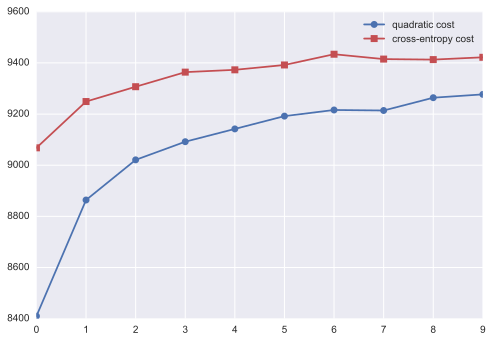

In [6]:
plt.plot(result1[1], 'bo-', label="quadratic cost")
plt.plot(result2[1], 'rs-', label="cross-entropy cost")
plt.legend(loc=0)
plt.show()

## 과최적화 문제

신경망 모형은 파라미터의 수가 다른 모형에 비해 많다.
 * (28x28)x(30)x(10) => 24,000
 * (28x28)x(100)x(10) => 80,000

이렇게 파라미터의 수가 많으면 과최적화 발생 가능성이 증가한다. 즉, 정확도가 나아지지 않거나 나빠져도 오차 함수는 계속 감소하는 현상이 발생한다.
 
 
 


* 예: 

```python
net = network2.Network([784, 30, 10], cost=network2.CrossEntropyCost) 
net.large_weight_initializer()
net.SGD(training_data[:1000], 400, 10, 0.5, evaluation_data=test_data, 
        monitor_evaluation_accuracy=True, monitor_training_cost=True)
```


<img src="http://neuralnetworksanddeeplearning.com/images/overfitting1.png" style="width:90%;">
<img src="http://neuralnetworksanddeeplearning.com/images/overfitting3.png" style="width:90%;">
<img src="http://neuralnetworksanddeeplearning.com/images/overfitting4.png" style="width:90%;">
<img src="http://neuralnetworksanddeeplearning.com/images/overfitting2.png" style="width:90%;">


## L2 정규화

이러한 과최적화를 방지하기 위해서는 오차 함수에 다음과 같이 정규화 항목을 추가하여야 한다.

$$
\begin{eqnarray} C = -\frac{1}{n} \sum_{j} \left[ y_j \ln z^L_j+(1-y_j) \ln
(1-z^L_j)\right] + \frac{\lambda}{2n} \sum_i w_i^2
\end{eqnarray}
$$

또는 

$$
\begin{eqnarray}  C = C_0 + \frac{\lambda}{2n}
\sum_i w_i^2,
\end{eqnarray}
$$

$$
\begin{eqnarray} 
  \frac{\partial C}{\partial w} & = & \frac{\partial C_0}{\partial w} + \frac{\lambda}{n} w \\ 
  \frac{\partial C}{\partial b} & = & \frac{\partial C_0}{\partial b}
\end{eqnarray}
$$

$$
\begin{eqnarray} 
  w & \rightarrow & w-\eta \frac{\partial C_0}{\partial w}-\frac{\eta \lambda}{n} w \\ 
  & = & \left(1-\frac{\eta \lambda}{n}\right) w -\eta \frac{\partial  C_0}{\partial w}
\end{eqnarray}
$$

## L2 정규화 구현 예


```python
def total_cost(self, data, lmbda, convert=False):
    """Return the total cost for the data set ``data``.  The flag
    ``convert`` should be set to False if the data set is the
    training data (the usual case), and to True if the data set is
    the validation or test data.  See comments on the similar (but
    reversed) convention for the ``accuracy`` method, above.
    """
    cost = 0.0
    for x, y in data:
        a = self.feedforward(x)
        if convert: y = vectorized_result(y)
        cost += self.cost.fn(a, y)/len(data)
    cost += 0.5*(lmbda/len(data))*sum(np.linalg.norm(w)**2 for w in self.weights)
    return cost

def update_mini_batch(self, mini_batch, eta, lmbda, n):
    """Update the network's weights and biases by applying gradient
    descent using backpropagation to a single mini batch.  The
    ``mini_batch`` is a list of tuples ``(x, y)``, ``eta`` is the
    learning rate, ``lmbda`` is the regularization parameter, and
    ``n`` is the total size of the training data set.
    """
    nabla_b = [np.zeros(b.shape) for b in self.biases]
    nabla_w = [np.zeros(w.shape) for w in self.weights]
    for x, y in mini_batch:
        delta_nabla_b, delta_nabla_w = self.backprop(x, y)
        nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
        nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
    self.weights = [(1-eta*(lmbda/n))*w-(eta/len(mini_batch))*nw for w, nw in zip(self.weights, nabla_w)]
    self.biases = [b-(eta/len(mini_batch))*nb for b, nb in zip(self.biases, nabla_b)]
```        


```python
net.SGD(training_data[:1000], 400, 10, 0.5, evaluation_data=test_data, lmbda = 0.1,
        monitor_evaluation_cost=True, monitor_evaluation_accuracy=True,
        monitor_training_cost=True, monitor_training_accuracy=True)
```

<img src="http://neuralnetworksanddeeplearning.com/images/regularized1.png" style="width:90%;" >
<img src="http://neuralnetworksanddeeplearning.com/images/regularized2.png" style="width:90%;" >

## L1 정규화

L2 정규화 대신 다음과 같은 L1 정규화를 사용할 수도 있다.

$$
\begin{eqnarray} C = -\frac{1}{n} \sum_{j} \left[ y_j \ln z^L_j+(1-y_j) \ln
(1-z^L_j)\right] + \frac{\lambda}{2n} \sum_i \| w_i \|
\end{eqnarray}
$$

$$
\begin{eqnarray}  
\frac{\partial C}{\partial w} = \frac{\partial C_0}{\partial w} + \frac{\lambda}{n} \, {\rm sgn}(w)
\end{eqnarray}
$$

$$
\begin{eqnarray}  
w \rightarrow w' = w-\frac{\eta \lambda}{n} \mbox{sgn}(w) - \eta \frac{\partial     C_0}{\partial w}
\end{eqnarray}
$$

## Dropout 정규화

Dropout 정규화 방법은 epoch 마다 임의의 hidden layer neurons $100p$%(보통 절반)를 dropout 하여 최적화 과정에 포함하지 않는 방법이다. 이 방법을 사용하면 가중치 값들 값들이 동시에 움직이는 것(co-adaptations) 방지하며 모형 averaging 효과를 가져다 준다.
<img src="http://neuralnetworksanddeeplearning.com/images/tikz31.png">

가중치 갱신이 끝나고 테스트 시점에는 가중치에 $p$를 곱하여 스케일링한다.

<img src="https://datascienceschool.net/upfiles/8e5177d1e7dd46a69d5b316ee8748e00.png">

## 가중치 초기화 (Weight initialization)

뉴런에 대한 입력의 수 $n_{in}$가 증가하면 가중 총합 $a$값의 표준편차도 증가한다.
 $$ \text{std}(a) \propto \sqrt{n_{in}} $$
 
<img src="http://neuralnetworksanddeeplearning.com/images/tikz32.png"> 


예를 들어 입력이 1000개, 그 중 절반이 1이면 표준편차는 약 22.4 이 된다.
 $$ \sqrt{501} \approx 22.4 $$

<img src="https://docs.google.com/drawings/d/1PZwr7wS_3gg7bXtp16XaZCbvxj4tMrfcbCf6GJhaX_0/pub?w=608&h=153">


이렇게 표준 편가가 크면 수렴이 느려지기 때문에 입력 수에 따라 초기화 가중치의 표준편차를 감소하는 초기화 값 조정이 필요하다.

$$\dfrac{1}{\sqrt{n_{in}} }$$

## 가중치 초기화 구현 예


```python
def default_weight_initializer(self):
    """Initialize each weight using a Gaussian distribution with mean 0
    and standard deviation 1 over the square root of the number of
    weights connecting to the same neuron.  Initialize the biases
    using a Gaussian distribution with mean 0 and standard
    deviation 1.
    Note that the first layer is assumed to be an input layer, and
    by convention we won't set any biases for those neurons, since
    biases are only ever used in computing the outputs from later
    layers.
    """
    self.biases = [np.random.randn(y, 1) for y in self.sizes[1:]]
    self.weights = [np.random.randn(y, x)/np.sqrt(x) for x, y in zip(self.sizes[:-1], self.sizes[1:])]
```

<img src="http://neuralnetworksanddeeplearning.com/images/weight_initialization_30.png" style="width:90%;">

## 소프트맥스 출력 

소프트맥스(softmax) 함수는 입력과 출력이 다변수(multiple variable) 인 함수이다. 최고 출력의 위치를 변화하지 않으면서 츨력의 합이 1이 되도록 조정하기 때문에 출력에 확률론적 의미를 부여할 수 있다. 보통 신경망의 최종 출력단에 적용한다.



$$
\begin{eqnarray} 
  y^L_j = \frac{e^{a^L_j}}{\sum_k e^{a^L_k}},
\end{eqnarray}
$$



$$
\begin{eqnarray}
  \sum_j y^L_j & = & \frac{\sum_j e^{a^L_j}}{\sum_k e^{a^L_k}} = 1
\end{eqnarray}
$$



<img src="https://www.tensorflow.org/versions/master/images/softmax-regression-scalargraph.png" style="width:60%;">


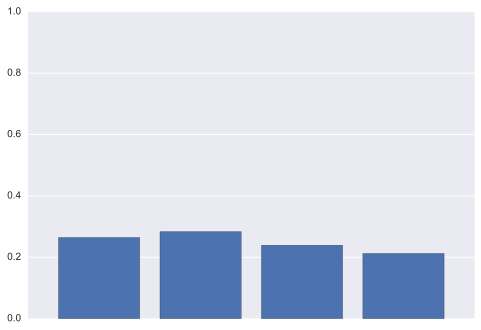

In [7]:
from ipywidgets import interactive
from IPython.display import Audio, display

def softmax_plot(z1=0, z2=0, z3=0, z4=0):
    exps = np.array([np.exp(z1), np.exp(z2), np.exp(z3), np.exp(z4)])
    exp_sum = exps.sum()
    plt.bar(range(len(exps)), exps/exp_sum)
    plt.xlim(-0.3, 4.1)
    plt.ylim(0, 1)
    plt.xticks([])
    
v = interactive(softmax_plot, z1=(-3, 5, 0.01), z2=(-3, 5, 0.01), z3=(-3, 5, 0.01), z4=(-3, 5, 0.01))
display(v)

## Hyper-Tangent Activation and Rectified Linear Unit (ReLu) Activation

시그모이드 함수 이외에도 하이퍼 탄젠트 및 ReLu 함수를 사용할 수도 있다.

하이퍼 탄젠트 activation 함수는 음수 값을 가질 수 있으며 시그모이드 activation 함수보다 일반적으로 수렴 속도가 빠르다.

$$
\begin{eqnarray}
 \tanh(w \cdot x+b), 
\end{eqnarray}
$$


$$
\begin{eqnarray}
  \tanh(a) \equiv \frac{e^a-e^{-a}}{e^a+e^{-a}}.
\end{eqnarray}
$$




$$
\begin{eqnarray} 
  \sigma(a) = \frac{1+\tanh(a/2)}{2},
\end{eqnarray}
$$



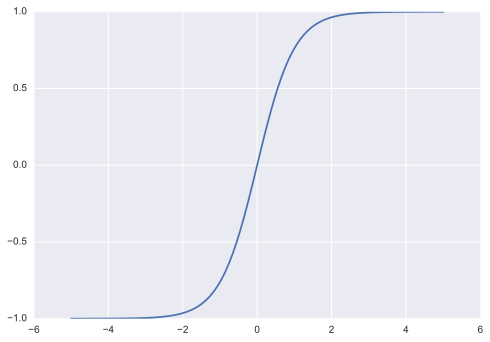

In [17]:
z = np.linspace(-5, 5, 100)
a = np.tanh(z)
plt.plot(z, a)
plt.show()

Rectified Linear Unit (ReLu) Activation 함수는 무한대 크기의 activation 값이 가능하며 가중치총합 $a$가 큰 경우에도 기울기(gradient)가 0 이되며 사라지지 않는다는 장점이 있다.

$$
\begin{eqnarray}
  \max(0, w \cdot x+b).
\end{eqnarray}
$$

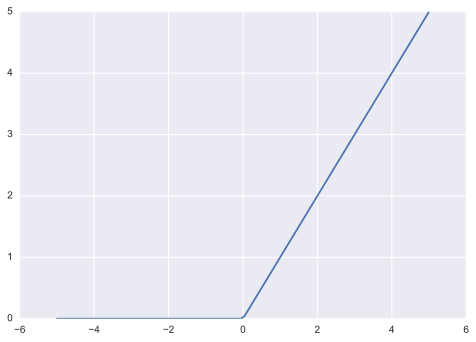

In [19]:
z = np.linspace(-5, 5, 100)
a = np.maximum(z, 0)
plt.plot(z, a)
plt.show()

## 그레디언트 소멸 문제 (Vanishing Gradient Problem)

은닉 계층의 수가 너무 증가하면 수렴 속도 및 성능이 급격히 저하된다.

* MNIST digits 예제
 * 1 hidden layer [784, 30, 10]: accuracy 96.48 percent 
 * 2 hidden layer [784, 30, 30, 10]: accuracy 96.90 percent 
 * 3 hidden layer [784, 30, 30, 30, 10]: accuracy 96.57 percent 
 * 4 hidden layer [784, 30, 30, 30, 30, 10]: accuracy 96.53 percent 
 

실제로 은닉 계층에서의 가중치의 값을 보면 입력 계층 쪽으로 갈수록 감소하는 것을 볼 수 있다.

<img src="http://neuralnetworksanddeeplearning.com/images/training_speed_2_layers.png" style="width:90%;">
<img src="http://neuralnetworksanddeeplearning.com/images/training_speed_3_layers.png" style="width:90%;">
<img src="http://neuralnetworksanddeeplearning.com/images/training_speed_4_layers.png" style="width:90%;"> 

가중치가 감소하는 원인은 backpropagation시에 오차가 뉴런을 거치면서 activation 함수의 기울기가 곱해지는데 이 값이 1보다 작아서 계속 크기가 감소하기 때문이다. 

* sigmoid activation의 경우 

$$ \sigma'(0) = 1/4 $$